# DQN FX Agent Training Notebook

This notebook contains a full, runnable implementation of the cleaned-up CNN+LSTM DQN agent and a synthetic data pipeline. Replace the synthetic data with your real `X_sequences` as needed.

In [1]:
# 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
print('torch:', torch.__version__)


torch: 2.8.0


In [2]:
# 2. Hyperparameters
sequence_length = 50        # ticks per RL step
num_features = 10           # features per tick
num_actions = 3             # 0=Buy,1=Sell,2=Hold
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995
lr = 1e-4
memory_size = 5000
num_episodes = 200
target_update_every = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [3]:
# 3. Model: CNN + LSTM DQN
class CNN_LSTM_DQN(nn.Module):
    def __init__(self, num_features, sequence_length, num_actions):
        super(CNN_LSTM_DQN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions)
        )
    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        q = self.fc(out)
        return q


In [4]:
# 4. Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, state_seq, action, reward, next_state_seq, done):
        self.memory.append((state_seq, action, reward, next_state_seq, done))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)


In [5]:
# 5. Trading Environment (FX)
class TradingEnvFX:
    def __init__(self, X_sequences, initial_cash=10000.0, transaction_cost=0.0005, price_idx=2):
        self.X = X_sequences
        self.n_ticks = X_sequences.shape[0]
        self.initial_cash = float(initial_cash)
        self.transaction_cost = float(transaction_cost)
        self.price_idx = int(price_idx)
        self.reset()
    def _price_at(self, t):
        return float(self.X[t, -1, self.price_idx])
    def _portfolio_value(self, price, cash=None, zar=None):
        if cash is None: cash = self.cash
        if zar is None: zar = self.zar_holdings
        return float(cash + (zar / price if price > 0 else 0.0))
    def reset(self):
        self.current_step = 0
        self.cash = self.initial_cash
        self.zar_holdings = 0.0
        self.last_buy_rate = None
        self.done = False
        return self.X[self.current_step]
    def step(self, action):
        if self.done:
            raise RuntimeError('Episode finished. Call reset().')
        price_t = self._price_at(self.current_step)
        value_before = self._portfolio_value(price_t)
        if action == 0:
            if self.cash > 0.0:
                zar_bought = self.cash * (1.0 - self.transaction_cost) * price_t
                self.zar_holdings += zar_bought
                self.cash = 0.0
                self.last_buy_rate = price_t
        elif action == 1:
            if self.zar_holdings > 0.0 and self.last_buy_rate is not None and price_t < self.last_buy_rate:
                usd_received = (self.zar_holdings / price_t) * (1.0 - self.transaction_cost)
                self.cash += usd_received
                self.zar_holdings = 0.0
                self.last_buy_rate = None
        # else hold
        self.current_step += 1
        if self.current_step >= self.n_ticks - 1:
            self.done = True
            next_state = self.X[self.n_ticks - 1]
            next_price = self._price_at(self.n_ticks - 1)
        else:
            next_state = self.X[self.current_step]
            next_price = self._price_at(self.current_step)
        value_after = self._portfolio_value(next_price)
        reward = value_after - value_before
        return next_state, reward, self.done, {
            'price_t': price_t,
            'price_next': next_price,
            'cash': self.cash,
            'zar': self.zar_holdings,
            'value_before': value_before,
            'value_after': value_after,
            'last_buy_rate': self.last_buy_rate
        }


In [6]:
# 6. DQN Agent
class DQNAgent:
    def __init__(self, sequence_shape, num_actions):
        self.model = CNN_LSTM_DQN(
            num_features=sequence_shape[1],
            sequence_length=sequence_shape[0],
            num_actions=num_actions
        ).to(device)
        self.target_model = CNN_LSTM_DQN(
            num_features=sequence_shape[1],
            sequence_length=sequence_shape[0],
            num_actions=num_actions
        ).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.memory = ReplayMemory(memory_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.epsilon = epsilon_start
    def select_action(self, state_seq):
        if random.random() < self.epsilon:
            return random.randrange(num_actions)
        with torch.no_grad():
            x = torch.tensor(state_seq, dtype=torch.float32, device=device).unsqueeze(0)
            q_values = self.model(x)
            return int(q_values.argmax(dim=1).item())
    def train_step(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        batch = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        state_seq = torch.tensor(np.array(states), dtype=torch.float32, device=device)
        next_state_seq = torch.tensor(np.array(next_states), dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.long, device=device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)
        q_values = self.model(state_seq)
        q_sa = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_values = self.target_model(next_state_seq).max(dim=1)[0]
            target = rewards + gamma * next_q_values * (1.0 - dones)
        loss = nn.MSELoss()(q_sa, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.epsilon = max(epsilon_end, self.epsilon * epsilon_decay)
        return float(loss.item())
    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())


In [7]:
# Step 1: Find project root dynamically (look for folder containing .env)
current_dir = os.getcwd()
project_root = current_dir

while not os.path.isfile(os.path.join(project_root, ".env")):
    # Go one directory up
    parent_dir = os.path.abspath(os.path.join(project_root, ".."))
    if parent_dir == project_root:
        raise FileNotFoundError(".env file not found in any parent directory")
    project_root = parent_dir

# Step 2: Load .env from project root
load_dotenv(os.path.join(project_root, ".env"))

True

In [15]:
# 8. Build Env & Agent
import numpy as np
import os

data_path = os.path.join(os.getenv("DATA_DIR_PROCESSED"), "X_sequences.npy")
X_sequences = np.load(data_path, allow_pickle=True)

env = TradingEnvFX(
    X_sequences=X_sequences,
    initial_cash=10000.0,
    transaction_cost=0.0005,
    price_idx=2
)
agent = DQNAgent(sequence_shape=(sequence_length, num_features), num_actions=num_actions)
print('Device:', device)


Device: cpu


In [17]:
# 9. Training Loop (short demo run)
total_rewards = []
losses = []
num_episodes_run = 5
for episode in range(1, num_episodes_run + 1):
    state = env.reset()
    done = False
    total_reward = 0.0
    steps = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        agent.memory.push(state, action, reward, next_state, done)
        loss = agent.train_step(batch_size)
        if loss is not None:
            losses.append(loss)
        state = next_state
        total_reward += reward
        steps += 1
    if episode % target_update_every == 0:
        agent.update_target()
    total_rewards.append(total_reward)
    print(f"Episode {episode:03d} | Steps {steps:4d} | Total Reward: {total_reward:8.2f} | Epsilon: {agent.epsilon:0.3f}")


Episode 001 | Steps 5347 | Total Reward: -10000.00 | Epsilon: 0.100
Episode 002 | Steps 5347 | Total Reward: -10000.00 | Epsilon: 0.100
Episode 003 | Steps 5347 | Total Reward: -10000.00 | Epsilon: 0.100
Episode 004 | Steps 5347 | Total Reward: -10000.00 | Epsilon: 0.100
Episode 005 | Steps 5347 | Total Reward: -476753.02 | Epsilon: 0.100


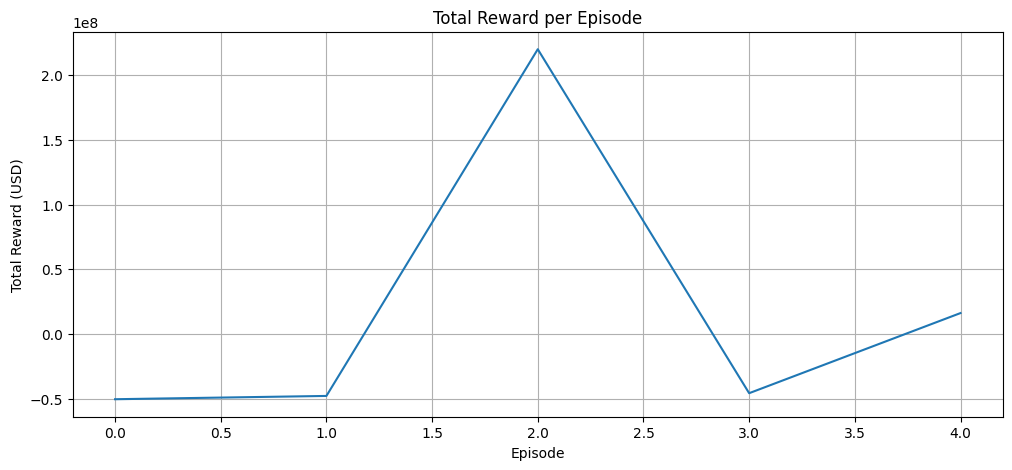

In [95]:
# 10. Plot training rewards and losses
plt.figure(figsize=(12,5))
plt.plot(total_rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward (USD)')
plt.savefig(os.path.join(os.getenv("MODEL_OUTPUT_IMG_PATH"), "total_rewards.png"))
plt.grid(True)



In [23]:
# 11. Save model
torch.save(agent.model.state_dict(), os.path.join(os.getenv("DATA_DIR_PROCESSED"), 'dqn_fx_model.pth'))
print('Saved model to /project/model/dqn_fx_model.pth')


Saved model to /project/model/dqn_fx_model.pth
